## Imports

In [50]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from torchvision import models, transforms, datasets
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix
)
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from imbalancer import Imbalancer
import pandas as pd

## GAN Model Setup and Path Initialization

In [51]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
epochs = 15

gan_variants = ["vanilla", "DCGAN", "WGAN"]
generators = [f"../saved_models/{g}_generator_fashion_mnist_epoch_500.pth" for g in gan_variants]
imbalanced_baseline_path = "../imbalanced_dataset_fashion_mnist/"

all_metrics_bal = {}
all_metrics_imbal = {}
for g in generators:
    print(g)

../saved_models/vanilla_generator_fashion_mnist_epoch_500.pth
../saved_models/DCGAN_generator_fashion_mnist_epoch_500.pth
../saved_models/WGAN_generator_fashion_mnist_epoch_500.pth


## Create Imbalanced Dataset

C:\Users\USER\AppData\Local\Temp\ipykernel_424\2356074229.py:8: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  images = np.stack([np.array(img) for img, _ in dataset])


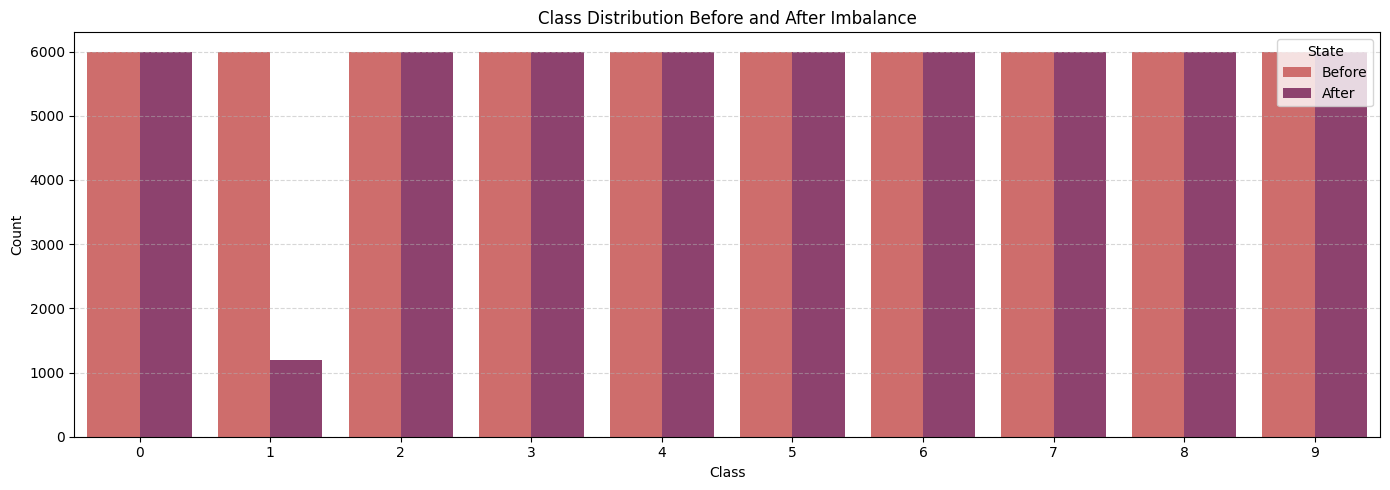

In [ ]:
import torch
transform = transforms.Compose([
    transforms.Resize(32),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])
dataset = datasets.FashionMNIST(root="./", train=True, download=True, transform=transform)
images = np.stack([np.array(img) for img, _ in dataset])
labels = [label for _, label in dataset]
minor_class = 1
imb = Imbalancer(images, labels, minor_class=minor_class, keep_ratio=0.2, output_path="../imbalanced_dataset_fashion_mnist")
imb.imbalance()
imb.visualize()
# imb.save() #uncomment to save a new imbalanced dataset
data = torch.load(imbalanced_baseline_path + "data.pt")      # shape: (N, C, H, W) or (N, features)
labels = torch.load(imbalanced_baseline_path + "labels.pt")  # shape: (N,)

# Filter for classes 0 and 1
mask = (labels == 0) | (labels == 1)
filtered_data = data[mask]
filtered_labels = labels[mask]

if filtered_data.shape[1] == 1:  # If single channel
        filtered_data = filtered_data.repeat(1, 3, 1, 1)
        
imbalanced_dataset = TensorDataset(filtered_data, filtered_labels)
imbalanced_loader = DataLoader(imbalanced_dataset, batch_size=32)

## Create The Model

In [54]:
def create_model():
    model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
    for param in model.parameters():
        param.requires_grad = False
    for param in model.fc.parameters():
        param.requires_grad = True
    model.fc = nn.Linear(model.fc.in_features, 2)
    return model.to(device)

## Get The Test Set from the Original Dataset

In [55]:
def get_official_fashionmnist_test(class0=0, class1=1, batch_size=32):
    transform = transforms.Compose([
        transforms.Resize(32),  # Changed from 2 to 28 (resizing to 2 would destroy the image)
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])
    ])
    
    test_data = datasets.FashionMNIST(root="./data", train=False, download=True, transform=transform)
    
    # Get indices first
    indices = (test_data.targets == class0) | (test_data.targets == class1)
    
    # Apply transforms by accessing through __getitem__
    transformed_data = torch.stack([test_data[i][0] for i in torch.where(indices)[0]])
    labels = (test_data.targets[indices] == class1).long()
    # Convert to 3-channel if needed (though FashionMNIST is grayscale)
    if transformed_data.shape[1] == 1:  # If single channel
        transformed_data = transformed_data.repeat(1, 3, 1, 1)  # [N, 3, H, W]
    
    return DataLoader(TensorDataset(transformed_data, labels), batch_size=batch_size, shuffle=False)
test_loader = get_official_fashionmnist_test()

## Balance The Dataset

In [56]:
from generators.vanilla import Generator as vanilla_gen
from generators.DCGAN import Generator as DCGAN_gen
from generators.WGAN import Generator as WGAN_gen

g_vanilla = vanilla_gen(100, 1024).to(device)
g_dc = DCGAN_gen(100, 1, 64).to(device)
g_w = WGAN_gen(100, 1, 32).to(device)

num_samples = 5000

g_vanilla.load_state_dict(torch.load(generators[0]))
g_dc.load_state_dict(torch.load(generators[1]))
g_w.load_state_dict(torch.load(generators[2]))

# Move filtered data to CUDA once
filtered_data_cuda = filtered_data.to(device)
filtered_labels_cuda = filtered_labels.to(device)

# Vanilla GAN
with torch.no_grad():  # Prevent gradient computation
    g_vanilla.eval()  # Set to evaluation mode
    x = torch.randn(num_samples, 100).to(device)
    fake_images = g_vanilla(x)
    fake_images = fake_images.view(num_samples, 1, 32, 32)
    fake_images = fake_images.repeat(1, 3, 1, 1)
    fake_images = fake_images.detach()  # Detach from computation graph

labels = torch.full((num_samples,), 1, dtype=torch.long, device=device)
full_images = torch.cat([filtered_data_cuda, fake_images], dim=0).detach()
full_labels = torch.cat([filtered_labels_cuda, labels], dim=0)
vanilla_dataset = TensorDataset(full_images.cpu(), full_labels.cpu())  # Move to CPU

# DCGAN
with torch.no_grad():
    g_dc.eval()
    x = torch.randn(num_samples, 100, 1, 1).to(device)
    fake_images = g_dc(x)
    fake_images = fake_images.repeat(1, 3, 1, 1)
    fake_images = fake_images.detach()

labels = torch.full((num_samples,), 1, dtype=torch.long, device=device)
full_images = torch.cat([filtered_data_cuda, fake_images], dim=0).detach()
full_labels = torch.cat([filtered_labels_cuda, labels], dim=0)
dc_dataset = TensorDataset(full_images.cpu(), full_labels.cpu())

# WGAN
with torch.no_grad():
    g_w.eval()
    x = torch.randn(num_samples, 100, 1, 1).to(device)
    fake_images = g_w(x)
    fake_images = fake_images.repeat(1, 3, 1, 1)
    fake_images = fake_images.detach()

labels = torch.full((num_samples,), 1, dtype=torch.long, device=device)
full_images = torch.cat([filtered_data_cuda, fake_images], dim=0).detach()
full_labels = torch.cat([filtered_labels_cuda, labels], dim=0)
w_dataset = TensorDataset(full_images.cpu(), full_labels.cpu())

In [57]:
balanced_datasets = [vanilla_dataset, dc_dataset, w_dataset]

## Split Dataset: Train and Validation

In [58]:
def create_train_val_loaders_from_dataset(dataset, batch_size=32, val_split=0.4):
    # Extract all data and labels from the dataset
    all_data = torch.stack([dataset[i][0] for i in range(len(dataset))])
    all_labels = torch.tensor([dataset[i][1] for i in range(len(dataset))])
    
    # Stratified split into train and val
    indices = np.arange(len(all_data))
    train_idx, val_idx = train_test_split(
        indices, test_size=val_split, stratify=all_labels, random_state=42
    )
    
    train_dataset = TensorDataset(all_data[train_idx], all_labels[train_idx])
    val_dataset = TensorDataset(all_data[val_idx], all_labels[val_idx])
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    return train_loader, val_loader

## Train Function

In [59]:
def train(model, train_loader, val_loader, epochs):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
    train_losses, val_losses = [], []
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            loss = criterion(model(x), y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        train_losses.append(total_loss / len(train_loader))

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(device), y.to(device)
                val_loss += criterion(model(x), y).item()
        val_losses.append(val_loss / len(val_loader))
        model.train()

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")
    return model, train_losses, val_losses

## Evaluation Function

In [60]:
def evaluate(model, loader):
    model.eval()
    y_true, y_pred, y_score = [], [], []
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            out = model(x)
            probs = torch.softmax(out, dim=1)
            preds = torch.argmax(probs, dim=1)
            y_true.extend(y.numpy())
            y_pred.extend(preds.cpu().numpy())
            y_score.extend(probs[:, 1].cpu().numpy())
    return {
        "accuracy": accuracy_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred),
        "recall": recall_score(y_true, y_pred),
        "f1": f1_score(y_true, y_pred),
        "auc": roc_auc_score(y_true, y_score),
        "conf_matrix": confusion_matrix(y_true, y_pred)
    }

## Different Plots

In [61]:
def plot_losses(train_losses, val_losses, title="Loss Curve"):
    plt.figure(figsize=(8, 5))
    plt.plot(train_losses, label="Train")
    plt.plot(val_losses, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [62]:
def plot_metrics(metrics_bal, metrics_imbal):
    keys = ['accuracy', 'precision', 'recall', 'f1', 'auc']
    bal_vals = [metrics_bal[k] for k in keys]
    imbal_vals = [metrics_imbal[k] for k in keys]
    x = np.arange(len(keys))
    width = 0.35
    plt.figure(figsize=(10, 6))
    plt.bar(x - width/2, bal_vals, width, label='Balanced (avg)')
    plt.bar(x + width/2, imbal_vals, width, label='Imbalanced (once)')
    plt.xticks(x, [k.capitalize() for k in keys])
    plt.ylabel("Score")
    plt.title("Metrics: Balanced (avg) vs Imbalanced (once)")
    plt.legend()
    plt.tight_layout()
    plt.show()

In [63]:
def plot_conf_matrix(cm, title):
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=['Class 0', 'Class 1'],
                yticklabels=['Class 0', 'Class 1'])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(title)
    plt.tight_layout()
    plt.show()

## Training On Balanced Datasets


--- Balanced Training: vanilla ---
Epoch 1/15, Train Loss: 0.4869, Val Loss: 0.3543
Epoch 2/15, Train Loss: 0.2803, Val Loss: 0.2513
Epoch 3/15, Train Loss: 0.2274, Val Loss: 0.2014
Epoch 4/15, Train Loss: 0.1961, Val Loss: 0.1809
Epoch 5/15, Train Loss: 0.1740, Val Loss: 0.1587
Epoch 6/15, Train Loss: 0.1637, Val Loss: 0.1493
Epoch 7/15, Train Loss: 0.1556, Val Loss: 0.1441
Epoch 8/15, Train Loss: 0.1500, Val Loss: 0.1387
Epoch 9/15, Train Loss: 0.1467, Val Loss: 0.1296
Epoch 10/15, Train Loss: 0.1374, Val Loss: 0.1234
Epoch 11/15, Train Loss: 0.1430, Val Loss: 0.1190
Epoch 12/15, Train Loss: 0.1272, Val Loss: 0.1199
Epoch 13/15, Train Loss: 0.1296, Val Loss: 0.1086
Epoch 14/15, Train Loss: 0.1281, Val Loss: 0.1112
Epoch 15/15, Train Loss: 0.1155, Val Loss: 0.1059


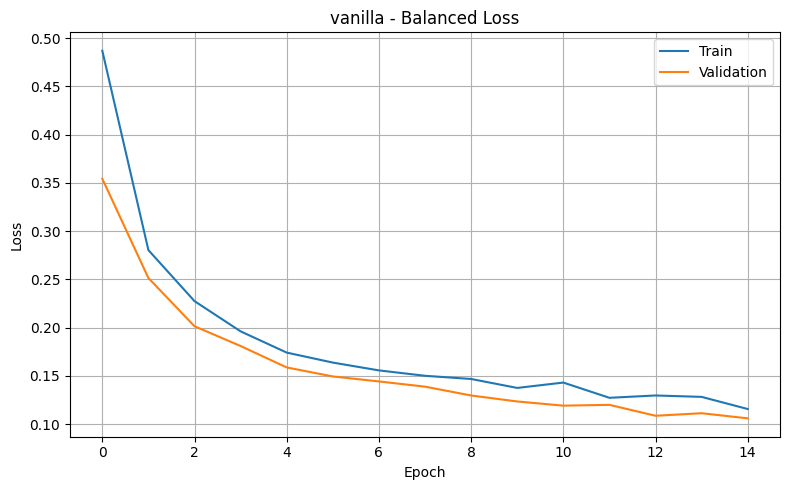


--- Balanced Training: DCGAN ---
Epoch 1/15, Train Loss: 0.5676, Val Loss: 0.4325
Epoch 2/15, Train Loss: 0.3650, Val Loss: 0.3273
Epoch 3/15, Train Loss: 0.2952, Val Loss: 0.2768
Epoch 4/15, Train Loss: 0.2498, Val Loss: 0.2494
Epoch 5/15, Train Loss: 0.2343, Val Loss: 0.2186
Epoch 6/15, Train Loss: 0.2208, Val Loss: 0.2146
Epoch 7/15, Train Loss: 0.2090, Val Loss: 0.2015
Epoch 8/15, Train Loss: 0.1995, Val Loss: 0.1987
Epoch 9/15, Train Loss: 0.2003, Val Loss: 0.1959
Epoch 10/15, Train Loss: 0.1919, Val Loss: 0.1872
Epoch 11/15, Train Loss: 0.1878, Val Loss: 0.1827
Epoch 12/15, Train Loss: 0.1805, Val Loss: 0.1796
Epoch 13/15, Train Loss: 0.1802, Val Loss: 0.1736
Epoch 14/15, Train Loss: 0.1769, Val Loss: 0.1750
Epoch 15/15, Train Loss: 0.1679, Val Loss: 0.1654


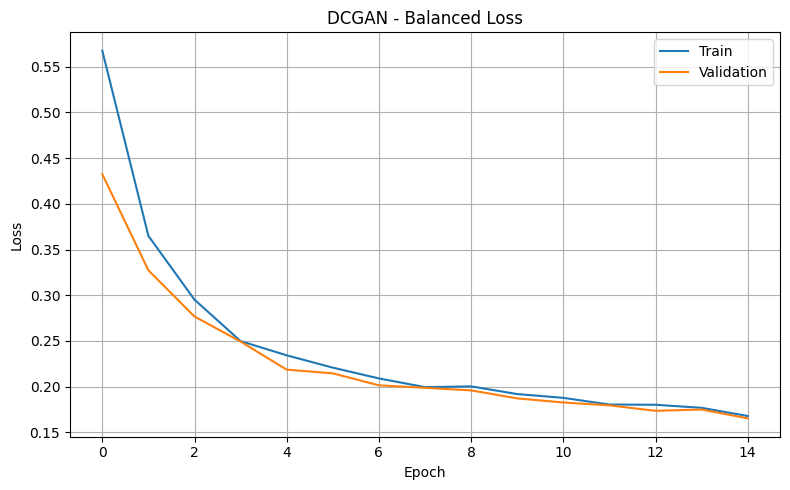


--- Balanced Training: WGAN ---
Epoch 1/15, Train Loss: 0.5913, Val Loss: 0.4200
Epoch 2/15, Train Loss: 0.3699, Val Loss: 0.3178
Epoch 3/15, Train Loss: 0.3037, Val Loss: 0.2729
Epoch 4/15, Train Loss: 0.2687, Val Loss: 0.2441
Epoch 5/15, Train Loss: 0.2416, Val Loss: 0.2366
Epoch 6/15, Train Loss: 0.2318, Val Loss: 0.2181
Epoch 7/15, Train Loss: 0.2254, Val Loss: 0.2007
Epoch 8/15, Train Loss: 0.2136, Val Loss: 0.1933
Epoch 9/15, Train Loss: 0.2036, Val Loss: 0.1893
Epoch 10/15, Train Loss: 0.1969, Val Loss: 0.1867
Epoch 11/15, Train Loss: 0.1884, Val Loss: 0.1800
Epoch 12/15, Train Loss: 0.1885, Val Loss: 0.1780
Epoch 13/15, Train Loss: 0.1885, Val Loss: 0.1751
Epoch 14/15, Train Loss: 0.1811, Val Loss: 0.1650
Epoch 15/15, Train Loss: 0.1784, Val Loss: 0.1688


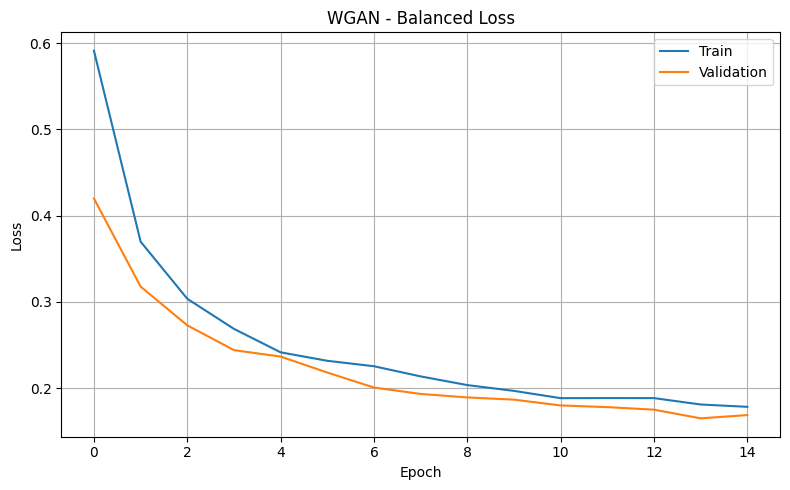

In [64]:
for i, (variant, dataset) in enumerate(zip(gan_variants, balanced_datasets)):
    print(f"\n--- Balanced Training: {variant} ---")
    
    # Create train/val loaders from the balanced dataset
    train_loader, val_loader = create_train_val_loaders_from_dataset(dataset)
    
    # Create and train model
    model = create_model()
    model, train_losses, val_losses = train(model, train_loader, val_loader, epochs)
    
    # Evaluate on test set
    metrics = evaluate(model, test_loader)
    plot_losses(train_losses, val_losses, title=f"{variant} - Balanced Loss")
    
    # Store metrics
    all_metrics_bal[variant] = metrics

## Training On Imbalanced Dataset


--- Imbalanced Training: Baseline (non-GAN) ---
Epoch 1/15, Train Loss: 0.3878, Val Loss: 0.3074
Epoch 2/15, Train Loss: 0.2733, Val Loss: 0.2229
Epoch 3/15, Train Loss: 0.2161, Val Loss: 0.1904
Epoch 4/15, Train Loss: 0.1831, Val Loss: 0.1633
Epoch 5/15, Train Loss: 0.1676, Val Loss: 0.1482
Epoch 6/15, Train Loss: 0.1497, Val Loss: 0.1452
Epoch 7/15, Train Loss: 0.1523, Val Loss: 0.1560
Epoch 8/15, Train Loss: 0.1441, Val Loss: 0.1394
Epoch 9/15, Train Loss: 0.1398, Val Loss: 0.1288
Epoch 10/15, Train Loss: 0.1280, Val Loss: 0.1184
Epoch 11/15, Train Loss: 0.1286, Val Loss: 0.1130
Epoch 12/15, Train Loss: 0.1263, Val Loss: 0.1152
Epoch 13/15, Train Loss: 0.1217, Val Loss: 0.1042
Epoch 14/15, Train Loss: 0.1205, Val Loss: 0.1125
Epoch 15/15, Train Loss: 0.1174, Val Loss: 0.1073


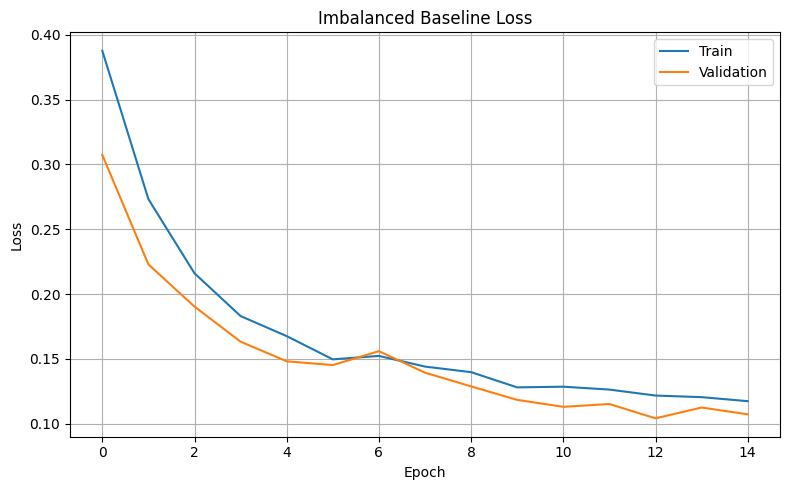

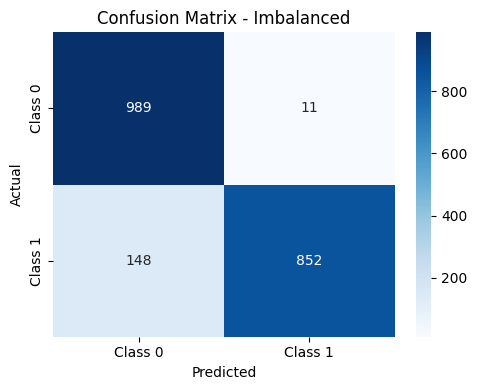

In [65]:
print("\n--- Imbalanced Training: Baseline (non-GAN) ---")

# Create train/val loaders from imbalanced dataset
imbalanced_train_loader, imbalanced_val_loader = create_train_val_loaders_from_dataset(imbalanced_dataset)

model = create_model()
model, train_losses, val_losses = train(model, imbalanced_train_loader, imbalanced_val_loader, epochs)
metrics_imbal = evaluate(model, test_loader)
plot_losses(train_losses, val_losses, title="Imbalanced Baseline Loss")
plot_conf_matrix(metrics_imbal["conf_matrix"], "Confusion Matrix - Imbalanced")

## Comparison Plot Of Baseline (imbalanced) VS. Balanced

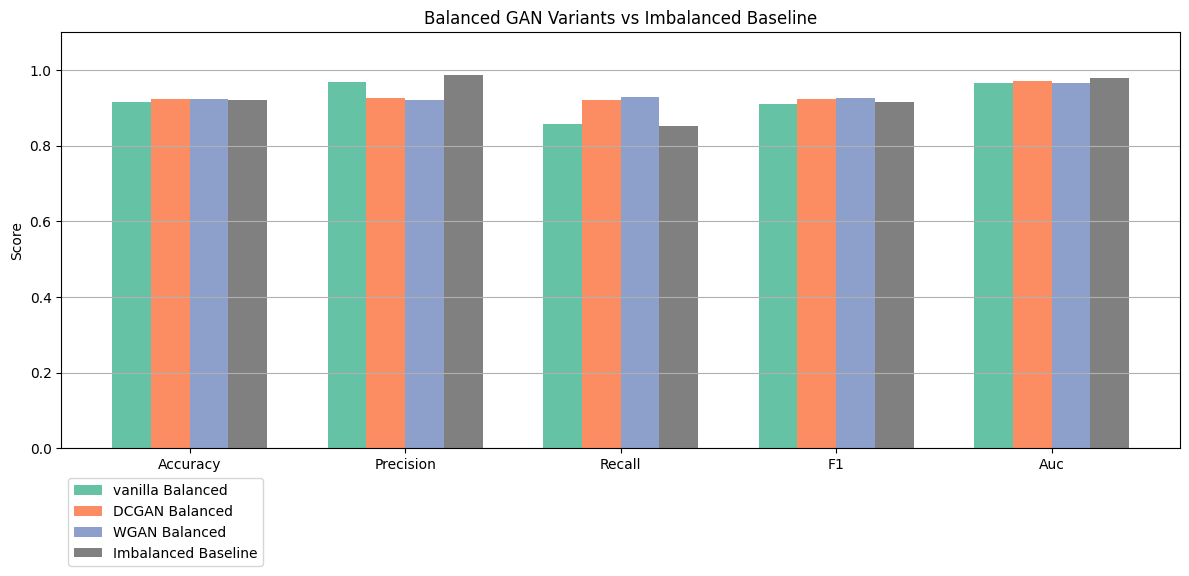

In [66]:
def plot_gan_vs_baseline(all_metrics_bal, metrics_imbal):
    keys = ['accuracy', 'precision', 'recall', 'f1', 'auc']
    variants = list(all_metrics_bal.keys())
    x = np.arange(len(keys))
    width = 0.18
    offset = np.linspace(-1.5 * width, 1.5 * width, len(variants) + 1)

    color_cycle = plt.cm.Set2.colors
    plt.figure(figsize=(12, 6))

    # Plot GAN variant metrics
    for i, variant in enumerate(variants):
        vals = [all_metrics_bal[variant][k] for k in keys]
        plt.bar(x + offset[i], vals, width, label=f"{variant} Balanced", color=color_cycle[i % len(color_cycle)])

    # Plot baseline (same position for all variants)
    baseline_vals = [metrics_imbal[k] for k in keys]
    plt.bar(x + offset[-1], baseline_vals, width, label="Imbalanced Baseline", color='gray')

    plt.xticks(x, [k.capitalize() for k in keys])
    plt.ylim(0, 1.1)
    plt.ylabel("Score")
    plt.title("Balanced GAN Variants vs Imbalanced Baseline")
    plt.legend(loc='lower left', bbox_to_anchor=(0, -0.3), ncol=1)
    plt.grid(True, axis='y')
    plt.tight_layout()
    plt.show()

plot_gan_vs_baseline(all_metrics_bal, metrics_imbal)

## Numerical Metrics Comparison & Improvement/Deterioration

In [67]:
def display_metrics_comparison_single_baseline(all_metrics_bal, baseline_metrics):
    keys = ['accuracy', 'precision', 'recall', 'f1', 'auc']

    for variant in all_metrics_bal.keys():
        print(f"\n=== {variant} vs Baseline ===")
        data = {
            "Baseline (Imbalanced)": [baseline_metrics[k] for k in keys],
            "Balanced": [all_metrics_bal[variant][k] for k in keys],
        }

        data["Absolute Diff"] = [
            all_metrics_bal[variant][k] - baseline_metrics[k] for k in keys
        ]
        data["% Improvement"] = [
            ((all_metrics_bal[variant][k] - baseline_metrics[k]) / baseline_metrics[k]) * 100
            if baseline_metrics[k] != 0 else 0
            for k in keys
        ]

        df = pd.DataFrame(data, index=[k.capitalize() for k in keys])
        df["% Improvement"] = df["% Improvement"].map("{:+.2f}%".format)
        df["Absolute Diff"] = df["Absolute Diff"].map("{:+.4f}".format)
        df["Baseline (Imbalanced)"] = df["Baseline (Imbalanced)"].map("{:.4f}".format)
        df["Balanced"] = df["Balanced"].map("{:.4f}".format)

        display(df)

# Use the already computed imbalanced baseline metrics here:
display_metrics_comparison_single_baseline(all_metrics_bal, metrics_imbal)


=== vanilla vs Baseline ===


,Baseline (Imbalanced),Balanced,Absolute Diff,% Improvement
Accuracy,0.9205,0.9145,-0.0060,-0.65%
Precision,0.9873,0.9694,-0.0178,-1.81%
Recall,0.8520,0.8560,+0.0040,+0.47%
F1,0.9147,0.9092,-0.0055,-0.60%
Auc,0.9779,0.9661,-0.0118,-1.21%



=== DCGAN vs Baseline ===


,Baseline (Imbalanced),Balanced,Absolute Diff,% Improvement
Accuracy,0.9205,0.9225,+0.0020,+0.22%
Precision,0.9873,0.9246,-0.0626,-6.34%
Recall,0.8520,0.9200,+0.0680,+7.98%
F1,0.9147,0.9223,+0.0077,+0.84%
Auc,0.9779,0.9696,-0.0083,-0.85%



=== WGAN vs Baseline ===


,Baseline (Imbalanced),Balanced,Absolute Diff,% Improvement
Accuracy,0.9205,0.9245,+0.0040,+0.43%
Precision,0.9873,0.9215,-0.0657,-6.66%
Recall,0.8520,0.9280,+0.0760,+8.92%
F1,0.9147,0.9248,+0.0101,+1.11%
Auc,0.9779,0.9652,-0.0127,-1.30%


## Confusion Matrices for All models

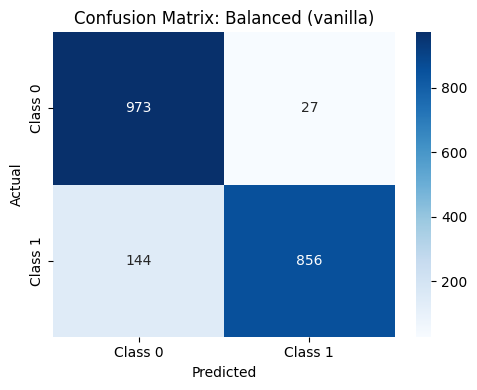

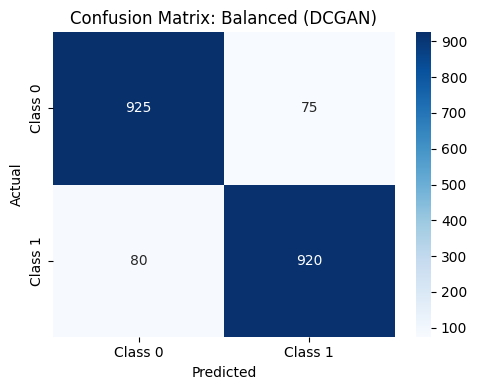

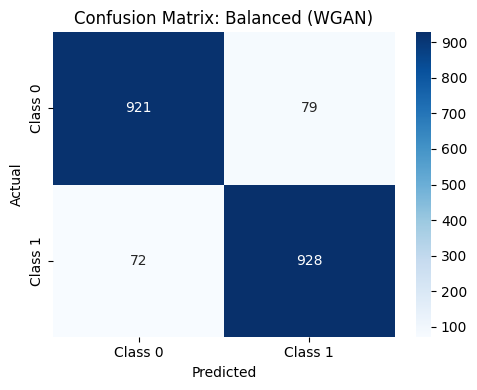

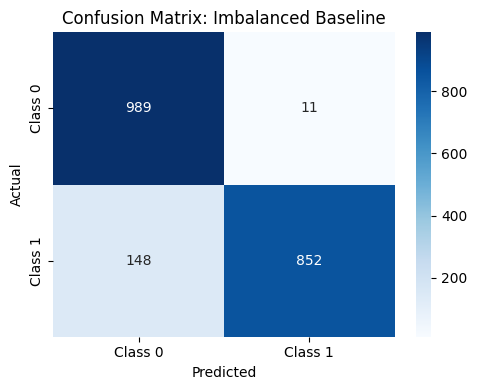

In [68]:
for variant in gan_variants:
    plot_conf_matrix(all_metrics_bal[variant]['conf_matrix'], f"Confusion Matrix: Balanced ({variant})")

# Plot the imbalanced baseline confusion matrix
plot_conf_matrix(metrics_imbal['conf_matrix'], "Confusion Matrix: Imbalanced Baseline")